**IMPORT LIBRARIES / PACKAGES.**

In [44]:
from numpy.random import multivariate_normal
import matplotlib.pyplot as mpl
%matplotlib inline
import numpy as np
import math

import sympy as sp
import statistics as st
from numpy import linspace
from scipy.stats import norm
from scipy.fft import fft, fftfreq
from scipy import signal
from scipy.constants import hbar
from scipy.optimize import curve_fit
#from colorednoise import *
from scipy.interpolate import UnivariateSpline

import joblib

sp.init_printing()

**MODIFIED FUNCTION FROM COLOREDNOISE PACKAGE.**

In [45]:
from numpy import sqrt, newaxis, mean
from numpy.fft import irfft, rfftfreq
from numpy.random import normal, seed
from numpy import sum as npsum
from numpy import arange
from scipy import interpolate
from matplotlib import mlab


def powerlaw_psd_gaussian(exponent, size, fmin):
    """Gaussian (1/f)**beta noise.

    Based on the algorithm in:
    Timmer, J. and Koenig, M.:
    On generating power law noise.
    Astron. Astrophys. 300, 707-710 (1995)

    Normalised to unit variance

    Parameters:
    -----------

    exponent : float
        The power-spectrum of the generated noise is proportional to

        S(f) = (1 / f)**beta
        flicker / pink noise:   exponent beta = 1
        brown noise:            exponent beta = 2

        Furthermore, the autocorrelation decays proportional to lag**-gamma
        with gamma = 1 - beta for 0 < beta < 1.
        There may be finite-size issues for beta close to one.

    shape : int or iterable
        The output has the given shape, and the desired power spectrum in
        the last coordinate. That is, the last dimension is taken as time,
        and all other components are independent.

    fmin : float, optional
        Low-frequency cutoff.
        Default: 0 corresponds to original paper. It is not actually
        zero, but 1/samples.

    Returns
    -------
    out : array
        The samples.


    Examples:
    ---------

    # generate 1/f noise == pink noise == flicker noise
    >>> import colorednoise as cn
    >>> y = cn.powerlaw_psd_gaussian(1, 5)
    """
    
    # Make sure size is a list so we can iterate it and assign to it.
    try:
        size = list(size)
    except TypeError:
        size = [size]
    
    # The number of samples in each time series
    samples = size[-1]
    
    # Calculate Frequencies (step = size of timestep)
    # Use fft functions for real output (-> hermitian spectrum)
    f = rfftfreq(samples)
    
    # Build scaling factors for all frequencies
    s_scale = f
    ## fmin = max(fmin, 1/samples) # Low frequency cutoff
    ix   = npsum(s_scale < fmin)   # Index of the cutoff
    if ix and ix < len(s_scale):
        s_scale[:ix] = s_scale[ix]
    s_scale = s_scale**(-exponent/2.)
    
    # Calculate theoretical output standard deviation from scaling
    w      = s_scale[1:].copy()
    w[-1] *= (1 + (samples % 2)) / 2. # correct f = +-0.5
    sigma = 2 * sqrt(npsum(w**2)) / samples
    
    # Adjust size to generate one Fourier component per frequency
    size[-1] = len(f)

    # Add empty dimension(s) to broadcast s_scale along last
    # dimension of generated random power + phase (below)
    dims_to_add = len(size) - 1
    s_scale     = s_scale[(newaxis,) * dims_to_add + (Ellipsis,)]
    
    # Generate scaled random power + phase
    seed()
    sr = normal(scale=s_scale, size=size)
    si = normal(scale=s_scale, size=size)
    
    # If the signal length is even, frequencies +/- 0.5 are equal
    # so the coefficient must be real.
    if not (samples % 2): si[...,-1] = 0
    
    # Regardless of signal length, the DC component must be real
    si[...,0] = 0
    
    # Combine power + corrected phase to Fourier components
    s  = sr + 1J * si
    
    # Transform to real time series & scale to unit variance
    y = irfft(s, n=samples, axis=-1) / sigma
    
    return y

**DEFINE CONSTANTS.**

In [46]:
U, t0, e0, dt, de = sp.symbols("U, t_0, epsilon0, Delta_t, Delta_epsilon")

**NOISE GENERATING FUNCTION**
- using colorednoise package
- beta: type of noise, 0 -> white noise, 1-> pink noise
- fmin = 1/number of samples
- powerlaw_psd_gaussian() calculates scaling factors, theoretical std dev, then scales noise spectrum to unit variance in time series

In [47]:
def gen_noise(noisetype,samples):
    
    if noisetype == "w":
        beta = 0
    elif noisetype == "p":
        beta = 1
    
    noise = powerlaw_psd_gaussian(beta, samples, 1/samples)
    return noise

**FUNCTION FOR CALCULATING AVERAGE PROBABILITY (AT SS).**

In [48]:
def prob(including,runs,num,enoise,tnoise,ntype):
    
    # number of samples
    n = num + 1
    
    # define constants
    U, t0, e0 = 25, 2.63*(10**-3),0    # in meV
    hbar = 0.000658284 # meV ns
    C = (16/U)
    
    # initialize empty Pfinal list
    Pfinal = np.array([0]*n)
    taulist = np.arange(0,n)
    
    for j in range(runs):
        
        # create empty P[j] list
        Plist = []
        
        # generate de[j], dt[j] noise spectrum
        
        if including == "de,dt":
            de = gen_noise(ntype,n) * enoise
            dtc = gen_noise(ntype,n) * (10**-3) * tnoise
        
        elif including == "de":
            de = gen_noise(ntype,n) * enoise
            dtc = np.array([0]*n)
        
        elif including == "dt":
            de = np.array([0]*n)
            dtc = gen_noise(ntype,n) * (10**-3) * tnoise
        
        else:
            return "error"
    
        for i in range(len(taulist)):

            tau = taulist[i]
            
            # calculate dJ[j][i]
            T1 = (t0**2) * (de[i])**2 / (U**2)
            T2 = t0*dtc[i]
            T3 = (dtc[i])**2
            dJ2o = C * (T1 + T2 + T3)

            # calculate P[j][i] and add it to P[j]
            P = math.cos((dJ2o/(2*hbar))*tau)**2
            Plist.append(P)

        Pfinal = Pfinal + Plist    # update Pfinal
        #if ((j+1) % 100 == 0) or (j == (runs-1)):
            #print(f"{j+1}", end=".")
       
    Paverage = Pfinal / runs       # average each element into Paverage list
    return Paverage

**FUNCTION FOR CALCULATING DEPHASING $e^{-\left<\frac{1}{2}(\delta J)^2\right>(\frac{\tau^2}{\hbar^2})}$ (AT SS).**

In [49]:
def fphi(including,runs,num,enoise,tnoise,ntype):
    
    # number of samples
    n = num + 1
    
    # define constants
    U, t0, e0 = 25, 2.63*(10**-3),0   # meV
    hbar = 0.000658284 # meV ns
    C = (16/U)
    
    # initialize empty phifinal list
    phifinal = np.array([0]*n)
    taulist = np.arange(0,n)
    
    for j in range(runs):
        
        # create empty phi[j] list
        philist = []
        
        # generate de[j], dt[j] noise spectrum
        
        if including == "de,dt":
            de = gen_noise(ntype,n) * enoise
            dtc = gen_noise(ntype,n) * (10**-3) * tnoise
        
        elif including == "de":
            de = gen_noise(ntype,n) * enoise
            dtc = np.array([0]*n)
        
        elif including == "dt":
            de = np.array([0]*n)
            dtc = gen_noise(ntype,n) * (10**-3) * tnoise
        
        else:
            return "error"
    
        for i in range(len(taulist)):

            #tau = taulist[i]
            
            # calculate dJ[j][i]
            T1 = (t0**2) * (de[i])**2 / (U**2)
            T2 = t0*dtc[i]
            T3 = (dtc[i])**2
            dJ2o = C * (T1 + T2 + T3)

            # calculate phi[j][i] and add it to phi[j]
            phi = ((dJ2o)**2)/(2)
            philist.append(phi)

        phifinal = phifinal + philist    # update phifinal
        #if ((j+1) % 100 == 0) or (j == (runs-1)):
            #print(f"{j+1}", end=".")
       
    phiaverage = phifinal / runs       # average each element into phiaverage list
    return (phiaverage)* (taulist/hbar)**2

**FITTING FUNCTION.**

In [50]:
def pfit(t, T):
    P = 0.5 + 0.5*np.exp(-(t**2)/(T**2))
    return P

def fit_curve(P):
    samples = 3 * 10**4
    tau2 = (np.arange(0,samples+1))
    par, cov = curve_fit(pfit, tau2, P)
    T = par
    #Pf = pfit(tau2, T)
    T = T * 10**-3
    return T[0]

**FUNCTIONS FOR RUNNING SIMULATIONS.**

In [51]:
colours = ["b", "r", "g", "c", "m", "y", "k"] * 5

In [52]:
# PROBABILITY MODEL.

from ipywidgets import IntProgress # For progress reporter
from IPython.display import display

def runpsim(including,runs,ntype,fname):

    # define variables
    
    samples = 3 * 10**4

    tau = (np.arange(0,samples+1))*(10**-6)

    start = 0
    stop = 1
    step = 0.01
    nrange = np.arange (start+step, stop+step, step)

    # run probability simulations
    
    listsize = len(nrange)
    problist = []
    
    print(f"simulation running for {ntype} noise...")
    
    progress_bar = IntProgress(min=0, max=listsize)
    display(progress_bar)

    for i in range(listsize):
        #print(f"simulating noise magnitude = {nrange[i]}: ", end="")
        
        if including == "dt":
            enoise = 0
            tnoise = nrange[i]
        elif including =="de":
            enoise = nrange[i]
            tnoise = 0
        elif including == "de,dt":
            enoise = nrange[i]
            tnoise = nrange[i]
        else:
            return "error."

        P = prob(including,runs,samples,enoise,tnoise,ntype)
        problist.append(P)
        
        progress_bar.value += 1

    '''
    for j in problist:
        print(j)

    fig= mpl.figure(figsize=(13,9))

    for k in range(listsize):
        mpl.plot(tau, problist[k], str(colours[k]+"-"), linewidth=0.3, label=f"average over {runs} runs, dt noise at {nrange[k]}.")

    mpl.axhline(y=0.5, linewidth=1, color='black', label="line of P = 0.5")
    mpl.title(f"P(tau) = <cos^2(dJ/2ℏ)> for {samples} samples (Quasistatic)")
    mpl.xlabel("tau (ms)", fontsize="large")
    mpl.ylabel("P(tau)", fontsize="large")
    mpl.legend(loc='upper right')
    mpl.show()
    '''

    # do curve fitting for each run of probability simulation
    
    Tlist = []

    for m in range(listsize):
        Tlist.append(fit_curve(problist[m]))

    # save Tlist to file
    savepath = "datadump/"+fname
    joblib.dump(Tlist, savepath)
    print("saved.", end="")
    
    #print(Tlist)

    fig= mpl.figure(figsize=(13,9))
    mpl.scatter(nrange, Tlist)
    mpl.plot(nrange, Tlist, "k-", linewidth=1, label=f"T values over range of {including} {ntype} noise magnitudes (probability model).")
    mpl.title(f"Tϕ values over range of {including} noise magnitude [{start}, {stop}]")
    mpl.xlabel(f"{including} (magnitude)", fontsize="large")
    mpl.ylabel("Tϕ (ms)", fontsize="large")
    mpl.legend(loc='upper right')
    mpl.show()


In [53]:
# DEPHASING MODEL.

from ipywidgets import IntProgress # For progress reporter
from IPython.display import display

def rundsim(including,runs,ntype,fname):

    # define variables
    
    samples = 3 * 10**4

    tau = (np.arange(0,samples+1))*(10**-6)

    start = 0
    stop = 1
    step = 0.01
    nrange = np.arange (start+step, stop+step, step)

    # run probability simulations
    
    listsize = len(nrange)
    dlist = []
    
    print(f"simulation running for {ntype} noise...")
    
    progress_bar = IntProgress(min=0, max=listsize)
    display(progress_bar)

    for i in range(listsize):
        #print(f"simulating noise magnitude = {nrange[i]}: ", end="")
        
        if including == "dt":
            enoise = 0
            tnoise = nrange[i]
        elif including =="de":
            enoise = nrange[i]
            tnoise = 0
        elif including == "de,dt":
            enoise = nrange[i]
            tnoise = nrange[i]
        else:
            return "error."

        D = fphi(including,runs,samples,enoise,tnoise,ntype)
        Dp = 0.5 + 0.5*np.exp(-D)
        dlist.append(Dp)
        
        progress_bar.value += 1

    '''
    for j in problist:
        print(j)

    fig= mpl.figure(figsize=(13,9))

    for k in range(listsize):
        mpl.plot(tau, problist[k], str(colours[k]+"-"), linewidth=0.3, label=f"average over {runs} runs, dt noise at {nrange[k]}.")

    mpl.axhline(y=0.5, linewidth=1, color='black', label="line of P = 0.5")
    mpl.title(f"P(tau) = <cos^2(dJ/2ℏ)> for {samples} samples (Quasistatic)")
    mpl.xlabel("tau (ms)", fontsize="large")
    mpl.ylabel("P(tau)", fontsize="large")
    mpl.legend(loc='upper right')
    mpl.show()
    '''
    
    # do curve fitting for each run of probability simulation
    
    Tlist = []

    for m in range(listsize):
        Tlist.append(fit_curve(dlist[m]))

    # save Tlist to file
    savepath = "datadump/"+fname
    joblib.dump(Tlist, savepath)
    print("saved.", end="")
    
    #print(Tlist)

    fig= mpl.figure(figsize=(13,9))
    mpl.scatter(nrange, Tlist)
    mpl.plot(nrange, Tlist, "k-", linewidth=1, label=f"T values over range of {including} {ntype} noise magnitudes (dephasing model).")
    mpl.title(f"Tϕ values over range of {including} noise magnitude [{start}, {stop}]")
    mpl.xlabel(f"{including} (magnitude)", fontsize="large")
    mpl.ylabel("Tϕ (ms)", fontsize="large")
    mpl.legend(loc='upper right')
    mpl.show()

**---------------------------------------------- ALL TESTS GO BELOW HERE ----------------------------------------------**

In [54]:
start = 0
stop = 1
step = 0.01
nrange = np.arange (start+step, stop+step, step)

RUNNING WHITE NOISE VS 1/F SIMULATIONS FOR NOISE IN ONLY DTC (PROBABILITY MODEL):


simulating white noise...
simulation running for w noise...


IntProgress(value=0)

saved.

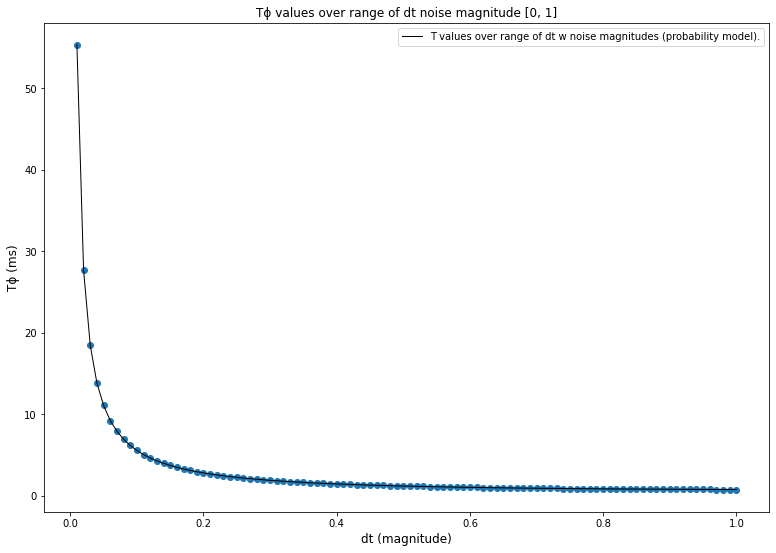

simulating 1/f noise...
simulation running for p noise...


IntProgress(value=0)

saved.

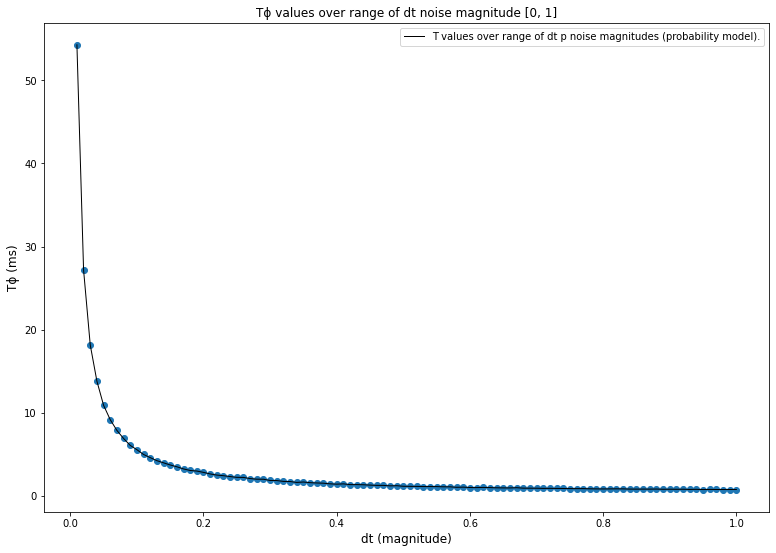

COMPARISONS:


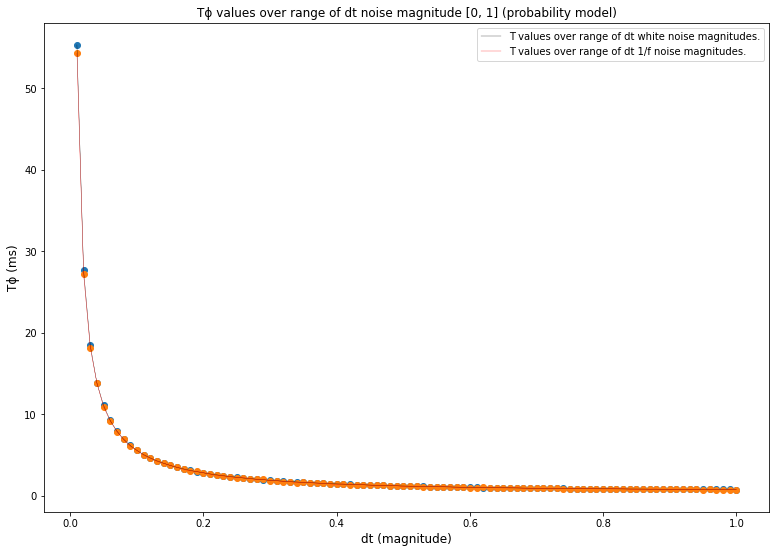

In [55]:
print("RUNNING WHITE NOISE VS 1/F SIMULATIONS FOR NOISE IN ONLY DTC (PROBABILITY MODEL):\n\n")

print("simulating white noise...")
runpsim("dt",200,"w",'white_dtc_p.txt')
print("simulating 1/f noise...")
runpsim("dt",200,"p",'pink_dtc_p.txt')

print("COMPARISONS:")

pwhite = joblib.load("datadump/white_dtc_p.txt")
ppink = joblib.load("datadump/pink_dtc_p.txt")

fig1= mpl.figure(figsize=(13,9))

mpl.scatter(nrange, pwhite)
mpl.plot(nrange, pwhite, "k-", linewidth=0.3, label=f"T values over range of dt white noise magnitudes.")
mpl.scatter(nrange, ppink)
mpl.plot(nrange, ppink, "r-", linewidth=0.3, label=f"T values over range of dt 1/f noise magnitudes.")

mpl.title(f"Tϕ values over range of dt noise magnitude [{start}, {stop}] (probability model)")
mpl.xlabel(f"dt (magnitude)", fontsize="large")
mpl.ylabel("Tϕ (ms)", fontsize="large")
mpl.legend(loc='upper right')
mpl.show()

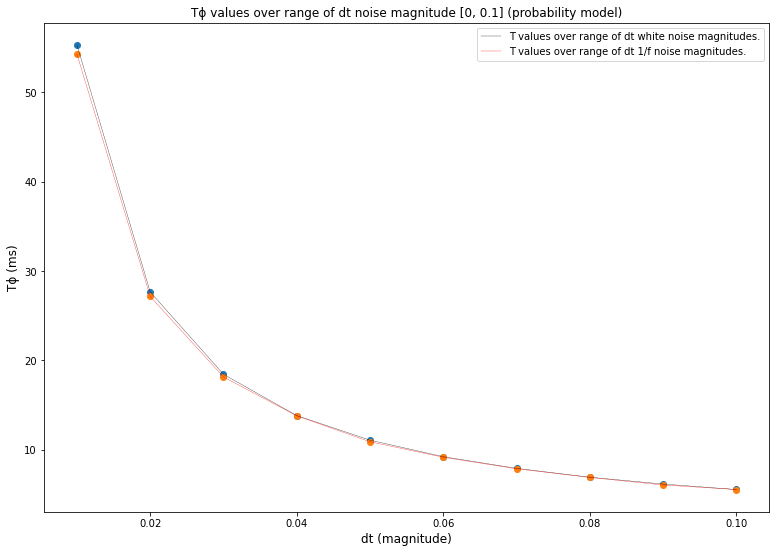

In [60]:
pwhite10 = pwhite[:len(nrange)//10]
ppink10 = ppink[:len(nrange)//10]

fig2= mpl.figure(figsize=(13,9))

mpl.scatter(nrange[:len(nrange)//10], pwhite10)
mpl.plot(nrange[:len(nrange)//10], pwhite10, "k-", linewidth=0.3, label=f"T values over range of dt white noise magnitudes.")
mpl.scatter(nrange[:len(nrange)//10], ppink10)
mpl.plot(nrange[:len(nrange)//10], ppink10, "r-", linewidth=0.3, label=f"T values over range of dt 1/f noise magnitudes.")

mpl.title(f"Tϕ values over range of dt noise magnitude [{start}, 0.1] (probability model)")
mpl.xlabel(f"dt (magnitude)", fontsize="large")
mpl.ylabel("Tϕ (ms)", fontsize="large")
mpl.legend(loc='upper right')
mpl.show()

RUNNING WHITE NOISE VS 1/F SIMULATIONS FOR NOISE IN ONLY DTC (DEPHASING MODEL):


simulating white noise...
simulation running for w noise...


IntProgress(value=0)

saved.

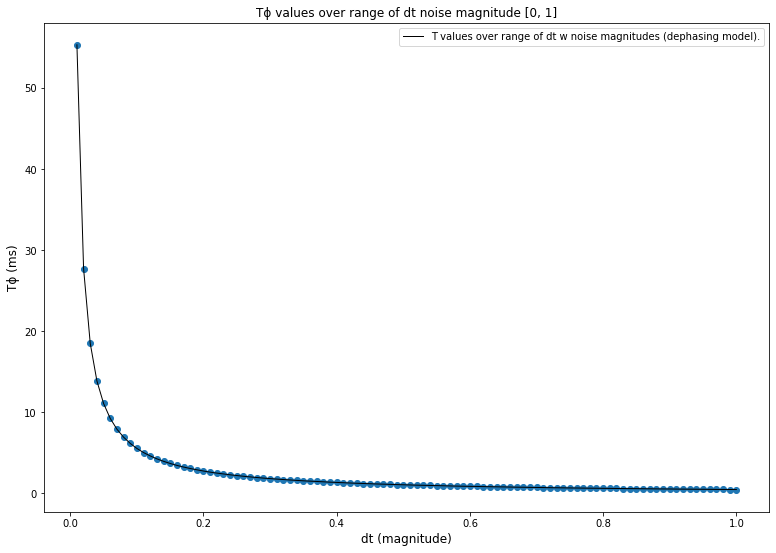

simulating 1/f noise...
simulation running for p noise...


IntProgress(value=0)

saved.

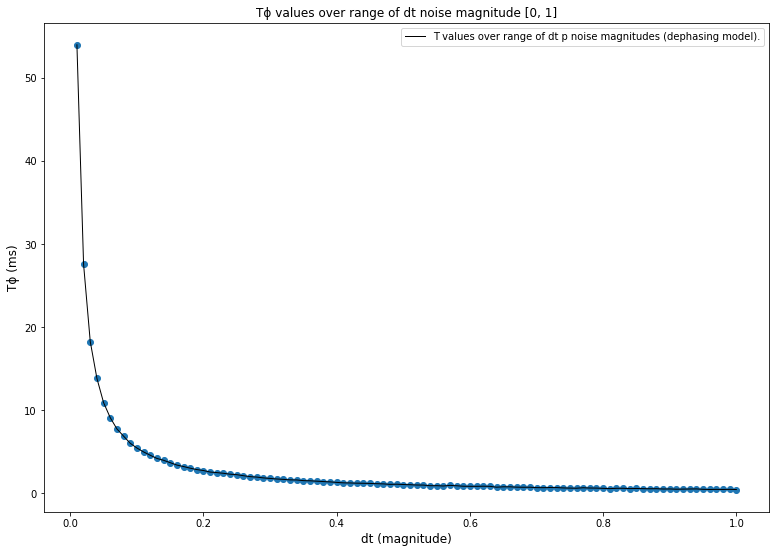

COMPARISONS:


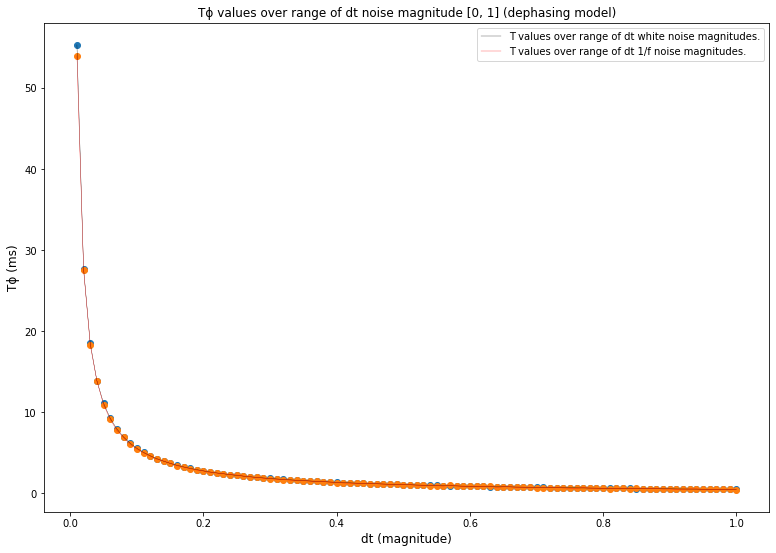

In [56]:
print("RUNNING WHITE NOISE VS 1/F SIMULATIONS FOR NOISE IN ONLY DTC (DEPHASING MODEL):\n\n")

print("simulating white noise...")
rundsim("dt",200,"w",'white_dtc_d.txt')
print("simulating 1/f noise...")
rundsim("dt",200,"p",'pink_dtc_d.txt')

print("COMPARISONS:")

dwhite = joblib.load("datadump/white_dtc_d.txt")
dpink = joblib.load("datadump/pink_dtc_d.txt")

fig1= mpl.figure(figsize=(13,9))

mpl.scatter(nrange, dwhite)
mpl.plot(nrange, dwhite, "k-", linewidth=0.3, label=f"T values over range of dt white noise magnitudes.")
mpl.scatter(nrange, dpink)
mpl.plot(nrange, dpink, "r-", linewidth=0.3, label=f"T values over range of dt 1/f noise magnitudes.")

mpl.title(f"Tϕ values over range of dt noise magnitude [{start}, {stop}] (dephasing model)")
mpl.xlabel(f"dt (magnitude)", fontsize="large")
mpl.ylabel("Tϕ (ms)", fontsize="large")
mpl.legend(loc='upper right')
mpl.show()

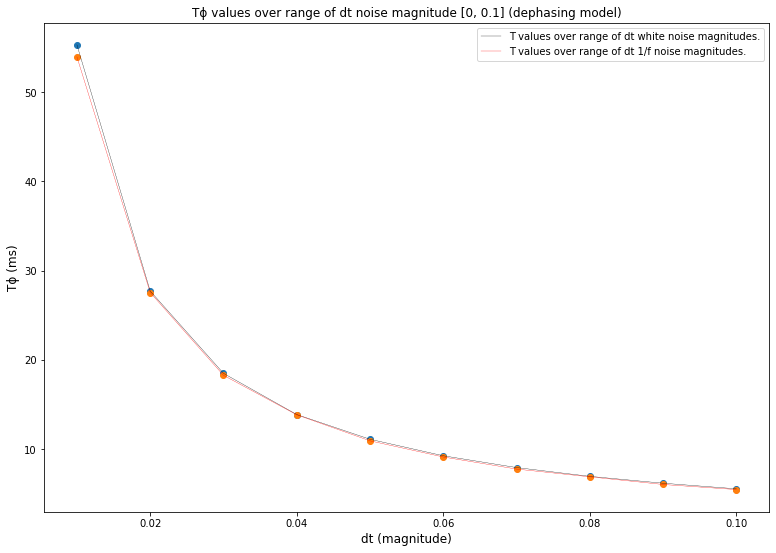

In [59]:
dwhite10 = dwhite[:len(nrange)//10]
dpink10 = dpink[:len(nrange)//10]

fig3= mpl.figure(figsize=(13,9))

mpl.scatter(nrange[:len(nrange)//10], dwhite10)
mpl.plot(nrange[:len(nrange)//10], dwhite10, "k-", linewidth=0.3, label=f"T values over range of dt white noise magnitudes.")
mpl.scatter(nrange[:len(nrange)//10], dpink10)
mpl.plot(nrange[:len(nrange)//10], dpink10, "r-", linewidth=0.3, label=f"T values over range of dt 1/f noise magnitudes.")

mpl.title(f"Tϕ values over range of dt noise magnitude [{start}, 0.1] (dephasing model)")
mpl.xlabel(f"dt (magnitude)", fontsize="large")
mpl.ylabel("Tϕ (ms)", fontsize="large")
mpl.legend(loc='upper right')
mpl.show()